### A8 - Using Deep Features for Image Classification

### Part 1 of 2.

### Due: Wednesday, May 30th on Canvas at 11:59 pm

Copyright ©2018 Emily Fox. All rights reserved. Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2018 for purposes of the course. No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored. Instructors interested in reusing these course materials should contact the author.

In [1]:
import turicreate as tc
import matplotlib.pyplot as plt
%matplotlib inline

### Load a common image analysis dataset

We will use a popular benchmark dataset in computer vision called CIFAR-10.  

(We've reduced the data to just 4 categories = {'cat','bird','automobile','dog'}.)

This dataset is already split into a training set and test set.  

In [2]:
image_train = tc.SFrame('/data/image_train_data/')
image_test = tc.SFrame('/data/image_test_data/')

This dataset has the following column labels.

In [3]:
image_train.column_names

<bound method SFrame.column_names of Columns:
	id	int
	image	Image
	label	str
	deep_features	array
	image_array	array

Rows: 2005

Data:
+-----+----------------------+------------+-------------------------------+
|  id |        image         |   label    |         deep_features         |
+-----+----------------------+------------+-------------------------------+
|  24 | Height: 32 Width: 32 |    bird    | [0.242871761322, 1.0954537... |
|  33 | Height: 32 Width: 32 |    cat     | [0.525087952614, 0.0, 0.0,... |
|  36 | Height: 32 Width: 32 |    cat     | [0.566015958786, 0.0, 0.0,... |
|  70 | Height: 32 Width: 32 |    dog     | [1.12979578972, 0.0, 0.0, ... |
|  90 | Height: 32 Width: 32 |    bird    | [1.71786928177, 0.0, 0.0, ... |
|  97 | Height: 32 Width: 32 | automobile | [1.57818555832, 0.0, 0.0, ... |
| 107 | Height: 32 Width: 32 |    dog     | [0.0, 0.0, 0.220677852631,... |
| 121 | Height: 32 Width: 32 |    bird    | [0.0, 0.23753464222, 0.0, ... |
| 136 | Height: 32 Width: 3

### Exploring the image data

Here's a function to display the images neatly

In [4]:
# image_rows is an SFrame
def show_images(image_rows):
    n = len(image_rows)
    width = 5 # change this to have more images in each row
    fig = plt.figure()
    fig.set_size_inches(width * 2, n / 2 + 1)
    for i in range(n):
        axis = fig.add_subplot(n / width + 1, width, i + 1)
        axis.set_axis_off()
        axis.set_title(image_rows[i]['label'])
        plt.imshow(image_rows[i]['image'].pixel_data)

Let's look at the first 10 images

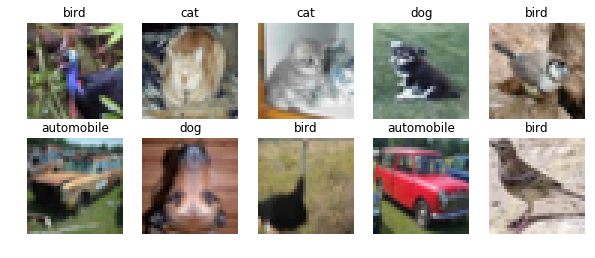

In [5]:
show_images(image_train[:10])

You can call this function and pass in a some rows from the SFrame to visualize the images.

### Train a classifier on the raw image pixels

We're going to first train a model that just uses the raw pixel data of each image. The column `image_array` contains a list of RGB values for each pixel. Each image is a 32 x 32 image, so there are 1024 pixels in total. Each pixel has is comprised of 3 values, one for Red, Green and Blue. So the length of `image_array` for each image is 3072.

Create a logistic classifier model that's trains on `image_array` features and call this model the `raw_pixel_model`. 

***Note :*** Set `validation_set=None` so that you get consistent answers.

In [7]:
# Students enter code here.
raw_pixel_model = tc.logistic_classifier.create(image_train, target='label', features = ['image_array'], validation_set=None)

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Logistic regression:

--------------------------------------------------------

Number of examples          : 2005

Number of classes           : 4

Number of feature columns   : 1

Number of unpacked features : 3072

Number of coefficients      : 9219

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 1         | 6        | 0.000012  | 1.926013     | 0.308728          |

| 2         | 8        | 1.000000  | 2.122982     | 0.375561          |

| 3         | 9        | 1.000000  | 2.252528     | 0.411471          |

| 4         | 10       | 1.000000  | 2.379051     | 0.442394          |

| 5         | 11       | 1.000000  | 2.503375     | 0.444888          |

| 6         | 12       | 1.000000  | 2.625551     | 0.445387          |

| 10        | 16       | 1.000000  | 3.140793     | 0.512219          |

+-----------+----------+-----------+--------------+-------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

### Make a prediction with the simple model based on raw pixels

Predict the labels for the first three images in the test set `raw_pixel_model`.

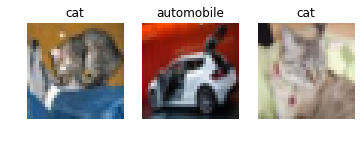

In [9]:
show_images(image_test[0:3])

In [11]:
# Students write code here
predictions = raw_pixel_model.predict(image_test[0:3])
predictions

dtype: str
Rows: 3
['bird', 'cat', 'bird']

***Question 1.1:*** How are the images labeled?

a) cat, dog, bird  
b) dog, bird, automobile  
c) automobile, automobile, dog  
d) bird, cat, bird  
e) bird, dog, dog

### Evaluating raw pixel model on test data

***Question 1.2:*** What is the accuracy of the model on the test data as a decimal accurate up to 3 decimal places (e.g. 85.4% accuracy -> 0.854)?

In [12]:
# Students write code here
def get_classification_accuracy(model, data, true_labels):
    # First get the predictions
    ## YOUR CODE HERE
    data['predictions'] = model.predict(data)
    
    # Compute the number of correctly classified examples
    ## YOUR CODE HERE
    num_correct = (data['predictions'] == true_labels).sum()

    # Then compute accuracy by dividing num_correct by total number of examples
    ## YOUR CODE HERE
    accuracy = num_correct * 1.0 / len(data)
    return accuracy

In [13]:
get_classification_accuracy(raw_pixel_model, image_test, image_test['label'])

0.477

### Can we improve the model using deep features?

We only have 2005 data points, so it is not possible to train a deep neural network effectively with so little data.  Instead, we will use transfer learning: using deep features trained on the full ImageNet dataset, we will train a simple model on this small dataset.

In [14]:
len(image_train)

2005

### Computing deep features for our images

The two lines below allow us to compute deep features. This computation takes a little while, so we have already computed them and saved the results as a column in the data you loaded. 

```python
image_train['deep_features'] = deep_learning_model.extract_features(image_train)
```

(Note that if you would like to compute such deep features and have a GPU on your machine, you should use the GPU enabled Turi Create, which will be significantly faster for this task.)

As we can see, the column deep_features already contains the pre-computed deep features for this data. 

In [15]:
image_train.head()

id,image,label,deep_features,image_array
24,Height: 32 Width: 32,bird,"[0.242871761322,1.09545373917, 0.0, ...","[73.0, 77.0, 58.0, 71.0,68.0, 50.0, 77.0, 69.0, ..."
33,Height: 32 Width: 32,cat,"[0.525087952614, 0.0,0.0, 0.0, 0.0, 0.0, ...","[7.0, 5.0, 8.0, 7.0, 5.0,8.0, 5.0, 4.0, 6.0, 7.0, ..."
36,Height: 32 Width: 32,cat,"[0.566015958786, 0.0,0.0, 0.0, 0.0, 0.0, ...","[169.0, 122.0, 65.0,131.0, 108.0, 75.0, ..."
70,Height: 32 Width: 32,dog,"[1.12979578972, 0.0, 0.0,0.778194487095, 0.0, ...","[154.0, 179.0, 152.0,159.0, 183.0, 157.0, ..."
90,Height: 32 Width: 32,bird,"[1.71786928177, 0.0, 0.0,0.0, 0.0, 0.0, ...","[216.0, 195.0, 180.0,201.0, 178.0, 160.0, ..."
97,Height: 32 Width: 32,automobile,"[1.57818555832, 0.0, 0.0,0.0, 0.0, 0.0, ...","[33.0, 44.0, 27.0, 29.0,44.0, 31.0, 32.0, 45.0, ..."
107,Height: 32 Width: 32,dog,"[0.0, 0.0,0.220677852631, 0.0, ...","[97.0, 51.0, 31.0, 104.0,58.0, 38.0, 107.0, 61.0, ..."
121,Height: 32 Width: 32,bird,"[0.0, 0.23753464222, 0.0,0.0, 0.0, 0.0, ...","[93.0, 96.0, 88.0, 102.0,106.0, 97.0, 117.0, ..."
136,Height: 32 Width: 32,automobile,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 7.5737862587, 0.0, ...","[35.0, 59.0, 53.0, 36.0,56.0, 56.0, 42.0, 62.0, ..."
138,Height: 32 Width: 32,bird,"[0.658935725689, 0.0,0.0, 0.0, 0.0, 0.0, ...","[205.0, 193.0, 195.0,200.0, 187.0, 193.0, ..."


### Given the deep features, let's train a classifier

Now train a new logistic classifier model that trains on the `deep_features` and call it the `deep_features_model`.

***Note :*** Set `validation_set=None` so that you get consistent answers.

In [16]:
# Students write code here
deep_features_model=tc.logistic_classifier.create(image_train, target='label', features = ['deep_features'], validation_set=None)

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

WARNING: Detected extremely low variance for feature(s) 'deep_features' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Logistic regression:

--------------------------------------------------------

Number of examples          : 2005

Number of classes           : 4

Number of feature columns   : 1

Number of unpacked features : 4096

Number of coefficients      : 12291

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 1         | 5        | 0.000125  | 1.035067     | 0.747631          |

| 2         | 9        | 0.250000  | 1.529153     | 0.766584          |

| 3         | 10       | 0.250000  | 1.709384     | 0.769576          |

| 4         | 11       | 0.250000  | 1.904623     | 0.775561          |

| 5         | 12       | 0.250000  | 2.082185     | 0.780549          |

| 6         | 13       | 0.250000  | 2.283261     | 0.791022          |

| 10        | 17       | 0.250000  | 2.999005     | 0.869825          |

+-----------+----------+-----------+--------------+-------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

### Apply the deep features model to first few images of test set

Predict the labels for the first three images in the test set `deep_features_model`.

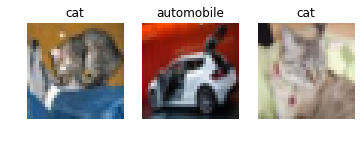

In [17]:
show_images(image_test[0:3])

In [18]:
# Students write code here
deep_features_model.predict(image_test[0:3])

dtype: str
Rows: 3
['cat', 'automobile', 'cat']

***Question 1.3:*** How are the images labeled?

a) cat, dog, bird  
b) dog, bird, automobile  
c) cat, automobile, cat  
d) automobile, dog, bird  
e) bird, dog, dog

### Compute test_data accuracy of deep_features_model

***Question 1.4:*** What is the accuracy of `deep_features_model` as a decimal accurate up to 3 decimal places (e.g. 85.4% accuracy -> 0.854)?

In [19]:
# Students write code here
get_classification_accuracy(deep_features_model, image_test, image_test['label'])

0.792